# Imports

In [78]:
import numpy as np
import math
import itertools
import heapq
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Solution

In [79]:
arr = np.array([(10, 1), (80, 6), (37, 3), (17, 1), (90, 10), (31, 2), (50, 4), (20, 2), (73, 4), (89, 8)])

$
1. \space 10000 \cdot \frac{M}{H + 100p}
$

$
2. \space 10000 \cdot \frac{M}{H + 100p} - 50000
$


do second expedition only if $ p <  \frac{M - 5H}{500} $





### Max value of p to make the expedition profitable

In [80]:
thresh = np.zeros(len(arr))
for i in range(len(arr)):
    mult, hab = arr[i][0], arr[i][1]
    thresh[i] = (mult - 5 * hab)/500
with np.printoptions(precision=3, suppress=True):
    print(thresh)

[0.01  0.1   0.044 0.024 0.08  0.042 0.06  0.02  0.106 0.098]


## Max Min
 consider the most pessimistic setting where
 is chosen by a malicious adversary in order to make our profit as small as possible.

In [81]:
def maximin1():
    """Solves the maximin optimization problem for a single expedition.

    Parameters
    ----------

    Returns
    -------
    argmax : list of tuple
        Maximizers.
    max_val : float
        Maximal profit.

    """
    max_val = float('-inf')
    argmax = []
    for i in range(len(arr)):
        mult, hab = arr[i][0], arr[i][1]
        val = mult / (hab + 100) * 10000
        if math.isclose(val, max_val):
            argmax.append((mult, hab))
        elif val > max_val:
            argmax = [(mult, hab)]
            max_val = val
    return (argmax, max_val)

In [82]:
maximin1()

([(89, 8)], 8240.74074074074)

In [83]:
def objective(p, mult1, hunt1, mult2, hunt2):
    """
    Compute the objective function for the given parameters.

    Parameters:
      p : list or array, where p[0] = p1 and p[1] = p2.
      mult1, hunt1: parameters for first expedition.
      mult2, hunt2: parameters for second expedition.

    Returns:
      The value of the function to minimize.
    """
    p1, p2 = p
    return mult1 / (hunt1 + 100*p1) + mult2 / (hunt2 + 100*p2)

def maximize2():
    """
    Solves the maximin optimization problem for two expeditions.
    For each pair of expeditions, it finds the optimum values p1 and p2
    within the constraints, computes the profit, and returns the expedition
    pair with the maximum profit.

    Returns:
      argmax1 : tuple
          First expedition as (multiplier, hunters).
      argmax2 : tuple
          Second expedition as (multiplier, hunters).
      max_val : float
          Maximum profit.
    """
    max_val = float('-inf')
    max_mult1, max_hunt1 = None, None
    max_mult2, max_hunt2 = None, None

    # Loop through all combinations of two distinct expeditions.
    for (mult1, hunt1), (mult2, hunt2) in itertools.combinations(arr, 2):
        # Define constraints for p1 and p2:
        constraints = (
            {'type': 'ineq', 'fun': lambda p: p[0]},                  # p1 >= 0
            {'type': 'ineq', 'fun': lambda p: p[1]},                  # p2 >= 0
            {'type': 'ineq', 'fun': lambda p: 1 - (p[0] + p[1])}      # p1 + p2 <= 1
        )
        # Set bounds for p1 and p2: here [0, 1] works well given the constraints.
        bounds = ((0, 1), (0, 1))
        # Initial guess must be feasible; [0.5, 0] is a valid starting point.
        initial_guess = [0.5, 0.0]

        # Solve the minimization problem.
        res = opt.minimize(objective, initial_guess, args=(mult1, hunt1, mult2, hunt2),
                           constraints=constraints, bounds=bounds, method='SLSQP')

        if not res.success:
            # If optimization fails, skip this pair.
            continue

        # The optimized minimum value of the objective.
        val_temp = res.fun

        # Compute the overall profit.
        val = -25000 + 7500 * val_temp

        if math.isclose(val, max_val):
            print("collision")
        if val > max_val:
            max_mult1, max_hunt1 = mult1, hunt1
            max_mult2, max_hunt2 = mult2, hunt2
            max_val = val

    return ((max_mult1, max_hunt1), (max_mult2, max_hunt2), max_val)

In [84]:
# Example: run maximize2 and print the best pair and value.
result = maximize2()
print("Best expeditions and maximal profit:")
print(result)

Best expeditions and maximal profit:
((90, 10), (89, 8), -2245.940253242381)


## Using a Prior

In [85]:
ratios = np.zeros(len(arr))
for i in range(len(arr)):
    mult, hab = arr[i][0], arr[i][1]
    ratios[i] = mult/hab
with np.printoptions(precision=3, suppress=True):
    print(ratios)

[10.    13.333 12.333 17.     9.    15.5   12.5   10.    18.25  11.125]


In [86]:
shares = ratios / np.sum(ratios)
with np.printoptions(precision=3, suppress=True):
    print("Natural prior:", shares, sep='\n')

Natural prior:
[0.077 0.103 0.096 0.132 0.07  0.12  0.097 0.077 0.141 0.086]


In [87]:
def fee(n):
    """Compute the fee for a total of n expeditions.

    Parameters
    ----------
    n : int
        Number of expeditions.

    Returns
    -------
    float
        Fee.
    """
    if n == 1:
        return 0
    if n == 2:
        return -50000

In [88]:
def payoff(mults, hunts, shares):
    """Compute the final profit after the expeditions.

    Parameters
    ----------
    mults : list of int
        Multipliers for each destination.
    hunts : list of int
        Hunters for each destination.
    shares : list of int
        Shares for each destination.

    Returns
    -------
    float
        Profit.
    """
    return 10000 * sum([mult/(hunt + 100*share) for (mult, hunt, share) in zip(mults, hunts, shares)]) + fee(len(mults))

In [89]:
def maximize_prior_top(shares, k):
    """Given the prior, compute solutions that yield top k profits.

    Parameters
    ----------
    shares : list of int
        Shares for each destination.
    k : int
        Number of solutions

    Returns
    -------
    list of tuple
        Top k profits and optimal expeditions.
    """
    datas = [(mult, hunt, share) for ((mult, hunt), share) in zip(arr, shares)]
    heap = []
    iterables = [itertools.combinations(datas, n_exp) for n_exp in range(1, 3)]
    for (i, data) in enumerate(itertools.chain.from_iterable(iterables)):
        mults = [tupl[0] for tupl in data]
        hunts = [tupl[1] for tupl in data]
        shares = [tupl[-1] for tupl in data]
        val = payoff(mults, hunts, shares)
        expeditions = list(zip(mults, hunts))
        if i < k:
            heapq.heappush(heap, (val, expeditions))
        elif val > heap[0][0]:
            heapq.heappop(heap)
            heapq.heappush(heap, (val, expeditions))
    return sorted(heap, reverse=True)

In [90]:
for i in range(10):
    shares = ratios**i
    shares = shares / np.sum(shares)
    res = maximize_prior_top(shares, 1)
    print("Exponent:", i, "Profit:", f"{res[0][0]:.2f}", "Optimal expeditions:", res[0][1])

Exponent: 0 Profit: 52142.86 Optimal expeditions: [(80, 6), (73, 4)]
Exponent: 1 Profit: 56566.66 Optimal expeditions: [(90, 10), (89, 8)]
Exponent: 2 Profit: 70658.70 Optimal expeditions: [(90, 10), (89, 8)]
Exponent: 3 Profit: 85605.23 Optimal expeditions: [(90, 10), (89, 8)]
Exponent: 4 Profit: 100070.58 Optimal expeditions: [(90, 10), (89, 8)]
Exponent: 5 Profit: 112950.96 Optimal expeditions: [(90, 10), (89, 8)]
Exponent: 6 Profit: 123630.03 Optimal expeditions: [(90, 10), (89, 8)]
Exponent: 7 Profit: 131966.18 Optimal expeditions: [(90, 10), (89, 8)]
Exponent: 8 Profit: 138149.99 Optimal expeditions: [(90, 10), (89, 8)]
Exponent: 9 Profit: 142876.92 Optimal expeditions: [(20, 2), (89, 8)]


## Using past year data to adjust prior

In [91]:
mult = np.array([
    100, 90, 89, 87, 85, 83, 82, 80, 79, 77,
    73, 70, 60, 55, 52, 47, 41, 35, 30, 27,
    24, 21, 17, 15, 12
])

hunt = np.array([
    8, 7, 5, 5, 5, 5, 5, 5, 5, 5,
    4, 4, 4, 4, 4, 3, 3, 3, 3, 3,
    2, 2, 2, 2, 2
])

past_ratios = mult/hunt

true_perc = np.array([
    1.348836074, 5.767443081, 2.720993972, 0.9303010114, 4.372104849,
    3.558136956, 6.44182824, 7.13946832, 6.162787002, 1.883712518,
    6.186049452, 7.418603709, 5.953443849, 5.558078804, 0.372180907,
    5.744162446, 6.581396295, 6.860435228, 6.023287011, 3.674380297,
    0, 0.7674409483, 3.255871615, 0.09302948621, 1.186027929
])

In [92]:
data = list(zip(past_ratios, true_perc))
ratio_to_perc = pd.DataFrame(data, columns=["ratio", "true_perc"]).sort_values("ratio")

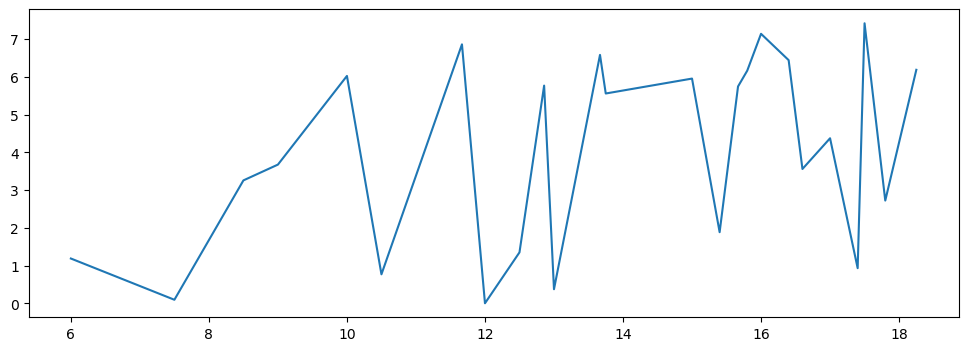

In [93]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(ratio_to_perc["ratio"], ratio_to_perc["true_perc"])

In [96]:
bin_labels = range(5)
ratio_to_perc["bin"], bin_edges = pd.cut(ratio_to_perc["ratio"], bins=5, labels=bin_labels, retbins=True)

bin_probs = ratio_to_perc.groupby("bin")["true_perc"].sum()/100

# Display result
for i, prob in enumerate(bin_probs):
    interval = (bin_edges[i], bin_edges[i + 1])
    print(f"Bin {i+1}: Range = {interval}, Probability = {prob:.4f}")

Bin 1: Range = (5.98775, 8.45), Probability = 0.0128
Bin 2: Range = (8.45, 10.9), Probability = 0.1372
Bin 3: Range = (10.9, 13.350000000000001), Probability = 0.1435
Bin 4: Range = (13.350000000000001, 15.8), Probability = 0.3188
Bin 5: Range = (15.8, 18.25), Probability = 0.3877


In [113]:
def compute_adj_shares(ratios, bin_probs, i=1):
    bin_assignments, bin_edges = pd.cut(ratios**i, bins=5, labels=False, retbins=True)

    # -- Step 2: Create a DataFrame to work with
    shares = ratios**i
    shares = shares / np.sum(shares)
    df = pd.DataFrame({
        "ratio": ratios**i,
        "prior_share": shares,
        "bin": bin_assignments
    })

    # -- Step 3: Rescale shares within each bin so their total matches historical bin_prob
    adjusted_shares = np.zeros_like(shares)

    for b in range(5):
        bin_mask = df["bin"] == b
        bin_total = df.loc[bin_mask, "prior_share"].sum()

        # If there's anything in this bin
        if bin_total > 0:
            # Rescale so that sum in this bin equals historical bin_prob
            scale = bin_probs[b] / bin_total
            adjusted_shares[bin_mask] = df.loc[bin_mask, "prior_share"] * scale

    # -- Step 4: Normalize adjusted shares to sum to 1 (optional)
    adjusted_shares /= adjusted_shares.sum()

    return adjusted_shares

# Show result
print("Adjusted shares:\n", compute_adj_shares(ratios, bin_probs, 1))

Adjusted shares:
 [0.00441054 0.14348895 0.04706153 0.18696376 0.00396949 0.31883581
 0.0476975  0.00441054 0.2007111  0.04245077]


In [115]:
for i in range(1, 10):
    adj_shares = compute_adj_shares(ratios, bin_probs, i)
    res = maximize_prior_top(adj_shares, 1)
    print("Exponent:", i, "Profit:", f"{res[0][0]:.2f}", "Optimal expeditions:", res[0][1])

Exponent: 1 Profit: 118495.67 Optimal expeditions: [(90, 10), (20, 2)]
Exponent: 2 Profit: 142631.50 Optimal expeditions: [(90, 10), (89, 8)]
Exponent: 3 Profit: 143590.30 Optimal expeditions: [(90, 10), (89, 8)]
Exponent: 4 Profit: 176044.71 Optimal expeditions: [(37, 3), (50, 4)]
Exponent: 5 Profit: 190256.17 Optimal expeditions: [(80, 6), (50, 4)]
Exponent: 6 Profit: 188937.18 Optimal expeditions: [(80, 6), (50, 4)]
Exponent: 7 Profit: 187860.61 Optimal expeditions: [(80, 6), (50, 4)]
Exponent: 8 Profit: 181950.15 Optimal expeditions: [(80, 6), (50, 4)]
Exponent: 9 Profit: 180933.67 Optimal expeditions: [(80, 6), (50, 4)]
